In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
#import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tongpython/cat-and-dog")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\janni\.cache\kagglehub\datasets\tongpython\cat-and-dog\versions\1


In [2]:
# Set Subclass of Data set for my Dataset
class PetDataSet(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes
    
dataset = PetDataSet(
    data_dir= os.path.join(path, "training_set/training_set")
)

0


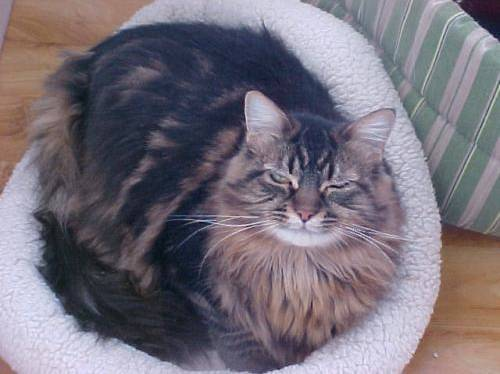

In [3]:
# Get length and show one image
len(dataset)
image, label = dataset[50]
print(label)
image

In [4]:
# Get a dictionary associating target values with folder names
data_dir = os.path.join(path, "training_set/training_set")
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'cats', 1: 'dogs'}


In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = os.path.join(path, "training_set/training_set")
test_folder = os.path.join(path, "test_set/test_set")

train_dataset = PetDataSet(train_folder, transform=transform)
test_dataset = PetDataSet(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class SimplePetClassifer(nn.Module):
    def __init__(self, num_classes=2):
        super(SimplePetClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output
    
model = SimplePetClassifer(num_classes=2)
print(str(model)[:500])


SimplePetClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fals


In [7]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = SimplePetClassifer(num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Add data augmentation like flip and random crop
        #1) flip horizontally
        if torch.rand(1) < 0.5:
            images = torch.flip(images, dims=[3])
        #2) random crop
        if torch.rand(1) < 0.5:
            crop_size = 64
            start_x = torch.randint(0, images.size(2) - crop_size + 1, (1,)).item()
            start_y = torch.randint(0, images.size(3) - crop_size + 1, (1,)).item()
            images = images[:, :, start_x:start_x + crop_size, start_y:start_y + crop_size]
            images = torch.nn.functional.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)


        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Testing phase
    # We compute the loss and accuracy on the test set
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        acumulated_correct = 0
        for images, labels in tqdm(test_loader, desc='Testing loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

            # You can also compute accuracy here if needed
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            # The predicted class is the one with highest probability
            _, predicted = torch.max(probabilities, 1)
            # Check correctness
            correct = (predicted == labels).sum().item()
            acumulated_correct += correct
        accuracy = acumulated_correct / len(test_loader.dataset)
    test_loss = running_loss / len(test_loader.dataset)
    val_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {test_loss}, Accuracy: {accuracy}")

Training loop:   0%|          | 0/251 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(7, 4))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Use test imagess from dataset
from glob import glob
test_images = glob(os.path.join(test_folder, "*", "*"))
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)